------------
<font size=8 color=yellowgreen>Supply Chain Optimization Model

---------------------

><font color=forestgreen>Introduction

This Jupyter Notebook presents an end-to-end optimization model for supply chain analytics. It uses mathematical modeling and data-driven decision-making to solve logistics and resource allocation problems. The model maximizes profit while respecting constraints like demand, stock levels, and lead time capacity.

><font color=forestgreen>Objective:

 Maximize total profit by optimizing production and sales volumes for various products.

><font color=forestgreen>Data Source:

supply_chain_data.csv (assumed to be in the working directory).

><font color=forestgreen>Objective :

 This project presents an end-to-end optimization model focusing on supply chain analytics, developed and documented in a Jupyter Notebook. It leverages mathematical modeling and data-driven decision-making to solve real-world logistics and resource allocation problems.

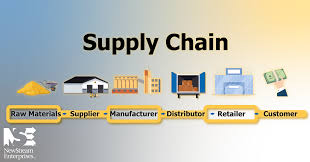

In [1]:
# Install the pulp library
%pip install pulp
import pulp

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, chi2_contingency
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

># <font color=chocolate> **Data Loading and Exploration**

In [3]:
df = pd.read_csv('/content/supply_chain_data.csv')
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632


In [4]:
# Dataset information
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product type             100 non-null    object 
 1   SKU                      100 non-null    object 
 2   Price                    100 non-null    float64
 3   Availability             100 non-null    int64  
 4   Number of products sold  100 non-null    int64  
 5   Revenue generated        100 non-null    float64
 6   Customer demographics    100 non-null    object 
 7   Stock levels             100 non-null    int64  
 8   Lead times               100 non-null    int64  
 9   Order quantities         100 non-null    int64  
 10  Shipping times           100 non-null    int64  
 11  Shipping carriers        100 non-null    object 
 12  Shipping costs           100 non-null    float64
 13  Supplier name            100 non-null    object 
 14  Location     

># <font color=chocolate>**Checking Missing Values**

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("Warning: Missing values detected:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values in the dataset.")

No missing values in the dataset.


In [6]:
# Summary statistics for key columns
key_columns = ['Price', 'Number of products sold', 'Stock levels', 'Manufacturing lead time', 'Manufacturing costs', 'Shipping costs']
print("\nSummary statistics for key columns:")
df[key_columns].describe()


Summary statistics for key columns:


,Price,Number of products sold,Stock levels,Manufacturing lead time,Manufacturing costs,Shipping costs
count,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000
mean,49.462461,460.990000,47.770000,14.77000,47.266693,5.548149
std,31.168193,303.780074,31.369372,8.91243,28.982841,2.651376
min,1.699976,8.000000,0.000000,1.00000,1.085069,1.013487
25%,19.597823,184.250000,16.750000,7.00000,22.983299,3.540248
50%,51.239831,392.500000,47.500000,14.00000,45.905622,5.320534
75%,77.198228,704.250000,73.000000,23.00000,68.621026,7.601695
max,99.171329,996.000000,100.000000,30.00000,99.466109,9.929816


><font color=cyan>Feasibility Diagnostics

Before optimization, check if the problem is feasible by analyzing total demand, stock, and lead time constraints.

In [7]:
# Calculate totals
total_demand = df['Number of products sold'].sum()
total_stock = df['Stock levels'].sum()
total_lead_time_capacity = 10000  # Assumed capacity
total_lead_time_required_min = (df['Number of products sold'] * df['Manufacturing lead time']).sum()
total_lead_time_required_max = (df['Stock levels'] * df['Manufacturing lead time']).sum()

print("Feasibility Overview:")
print(f"- Total Demand: {total_demand} units")
print(f"- Total Stock Capacity: {total_stock} units")
print(f"- Total Lead Time Capacity: {total_lead_time_capacity} units")
print(f"- Minimum Lead Time Required (at demand): {total_lead_time_required_min} units")
print(f"- Maximum Lead Time Required (at stock limit): {total_lead_time_required_max} units")

if total_demand > total_stock:
    print("Warning: Total demand exceeds total stock levels. Production-to-demand constraints may be infeasible.")
if total_lead_time_required_min > total_lead_time_capacity:
    print("Warning: Minimum lead time required exceeds capacity; time capacity is binding.")

Feasibility Overview:
- Total Demand: 46099 units
- Total Stock Capacity: 4777 units
- Total Lead Time Capacity: 10000 units
- Minimum Lead Time Required (at demand): 667765 units
- Maximum Lead Time Required (at stock limit): 69156 units


><font color=cyan>Profit Margin Calculation

Calculate profit margin for each product as Price minus Manufacturing Costs minus Shipping Costs.




In [8]:
# Add profit margin column
df['Profit_Margin'] = df['Price'] - df['Manufacturing costs'] - df['Shipping costs']

print(f"Average Profit Margin: ${df['Profit_Margin'].mean():.2f} (min {df['Profit_Margin'].min():.2f}, max {df['Profit_Margin'].max():.2f})")

Average Profit Margin: $-3.35 (min -97.21, max 91.34)


## <font color=cyan>Optimization Model Formulation
We use PuLP to formulate and solve a Linear Programming (LP) problem to maximize profit.

### <font color=skyblue>Decision Variables:

Production_i: Units to produce for product i (continuous, >=0)
Sold_i: Units sold for product i (continuous, >=0)
Objective: Maximize sum(Profit_Margin_i * Sold_i)

### <font color=skyblue>Constraints:

- Sold_i <= Demand_i
- Sold_i <= Production_i
- Production_i <= Stock Levels_i
- Total Lead Time <= Capacity



In [9]:
import pulp

# Define the problem
prob = pulp.LpProblem("Supply_Chain_Profit_Maximization", pulp.LpMaximize)

# Indices
indices = df.index.to_list()

# Decision variables
production = pulp.LpVariable.dicts("Production", indices, lowBound=0, cat='Continuous')
sold = pulp.LpVariable.dicts("Sold", indices, lowBound=0, cat='Continuous')

# Objective function
prob += pulp.lpSum([(df.loc[i, 'Profit_Margin']) * sold[i] for i in indices])

# Constraints
for i in indices:
    prob += sold[i] <= df.loc[i, 'Number of products sold'], f"Demand_limit_{i}"
    prob += sold[i] <= production[i], f"Sales_le_production_{i}"
    prob += production[i] <= df.loc[i, 'Stock levels'], f"Stock_limit_{i}"

prob += pulp.lpSum([df.loc[i, 'Manufacturing lead time'] * production[i] for i in indices]) <= total_lead_time_capacity, "Lead_time_capacity"

# Solve the problem
solution_status = prob.solve(pulp.PULP_CBC_CMD(msg=1))
print("Solver Status:", pulp.LpStatus[prob.status])

Solver Status: Optimal


>Results Extraction and Analysis

If the solution is optimal, extract and display key results.

In [10]:
if pulp.LpStatus[prob.status] == 'Optimal' or pulp.LpStatus[prob.status] == 'Feasible':
    # Add results to dataframe
    df['Optimal_Production'] = [production[i].value() for i in indices]
    df['Optimal_Sold'] = [sold[i].value() for i in indices]

    # Calculate totals
    total_profit = pulp.value(prob.objective)
    total_revenue = sum(df.loc[i, 'Price'] * df.loc[i, 'Optimal_Sold'] for i in indices)
    total_manufacturing_cost = sum(df.loc[i, 'Manufacturing costs'] * df.loc[i, 'Optimal_Production'] for i in indices)
    total_shipping_cost = sum(df.loc[i, 'Shipping costs'] * df.loc[i, 'Optimal_Sold'] for i in indices)
    total_lead_time_used = sum(df.loc[i, 'Manufacturing lead time'] * df.loc[i, 'Optimal_Production'] for i in indices)
    lead_time_slack = total_lead_time_capacity - total_lead_time_used
    stock_utilization = (df['Optimal_Production'].sum() / total_stock) * 100 if total_stock > 0 else np.nan

    print("Optimization Results:")
    print(f"- Total Profit: ${total_profit:,.2f}")
    print(f"- Total Revenue: ${total_revenue:,.2f}")
    print(f"- Total Manufacturing Cost: ${total_manufacturing_cost:,.2f}")
    print(f"- Total Shipping Cost: ${total_shipping_cost:,.2f}")
    print(f"- Total Lead Time Used: {total_lead_time_used:,.2f} / {total_lead_time_capacity} (Slack: {lead_time_slack:.2f})")
    print(f"- Stock Utilization: {stock_utilization:.1f}%")

    # Profit contribution
    df['Profit_Contribution'] = df['Profit_Margin'] * df['Optimal_Sold']

    # Top products
    top_products = df.nlargest(10, 'Profit_Contribution')[['SKU', 'Product type', 'Profit_Contribution', 'Optimal_Production', 'Optimal_Sold']]
    print("\nTop 10 Products by Profit Contribution:")
    print(top_products.to_string(index=False))
else:
    print("No feasible/optimal solution found. Status:", pulp.LpStatus[prob.status])

Optimization Results:
- Total Profit: $63,383.03
- Total Revenue: $104,015.22
- Total Manufacturing Cost: $33,174.94
- Total Shipping Cost: $7,457.25
- Total Lead Time Used: 10,000.00 / 10000 (Slack: 0.00)
- Stock Utilization: 26.7%

Top 10 Products by Profit Contribution:
  SKU Product type  Profit_Contribution  Optimal_Production  Optimal_Sold
SKU64     skincare          5573.966079                73.0          73.0
SKU59    cosmetics          5463.391351               100.0         100.0
SKU52     skincare          5134.971413                64.0          64.0
SKU14     skincare          4932.366578                54.0          54.0
SKU26     haircare          4423.062926                59.0          59.0
SKU55     haircare          4318.163369                97.0          97.0
SKU62    cosmetics          3823.216846                86.0          86.0
SKU32     skincare          3819.734392                89.0          89.0
SKU12     haircare          3756.682885               100.0 

## <font color=cyan>Visualizations
Add several visualizations to better understand the data and results.

1. Distribution of Product Types

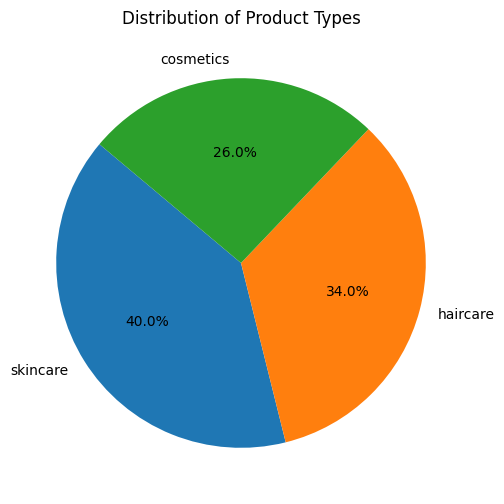

In [11]:
# Pie chart for product types
product_type_counts = df['Product type'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(product_type_counts, labels=product_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Product Types')
plt.show()

><font color=cyan>2. Profit Margin vs. Price Scatter Plot



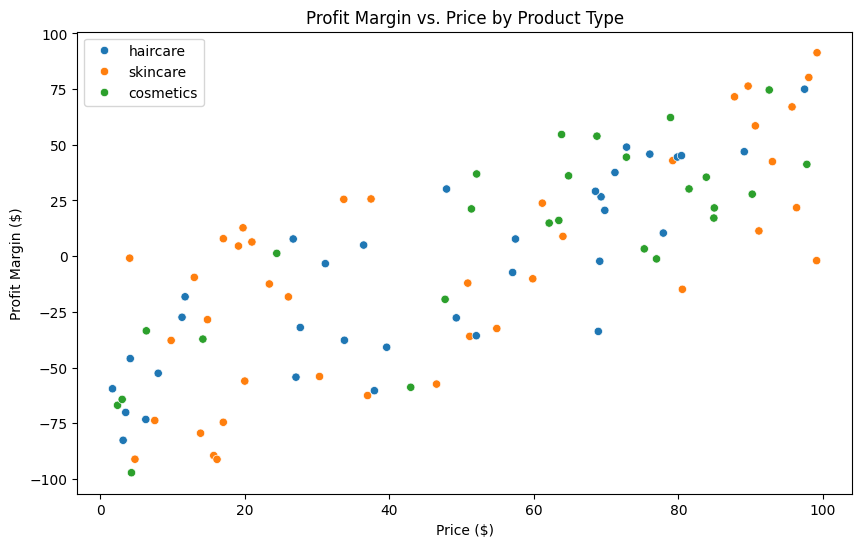

In [12]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Price', y='Profit_Margin', hue='Product type')
plt.title('Profit Margin vs. Price by Product Type')
plt.xlabel('Price ($)')
plt.ylabel('Profit Margin ($)')
plt.legend()
plt.show()

><font color=cyan>3. Demand vs. Optimal Production (First 20 Products)

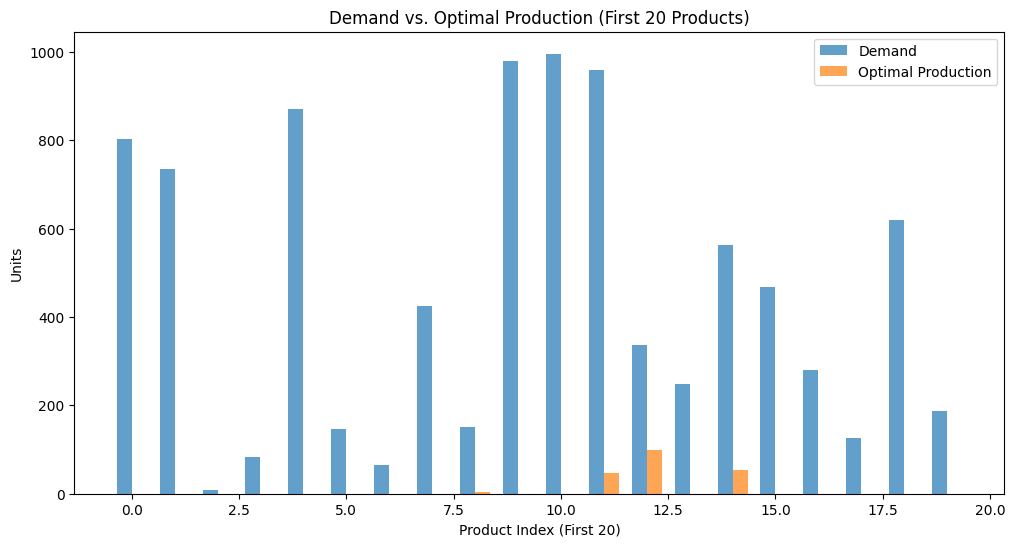

In [13]:
# Bar chart for first 20 products
plt.figure(figsize=(12, 6))
idx = df.index[:20]
w = 0.35
plt.bar(idx - w/2, df.loc[idx, 'Number of products sold'], width=w, label='Demand', alpha=0.7)
plt.bar(idx + w/2, df.loc[idx, 'Optimal_Production'], width=w, label='Optimal Production', alpha=0.7)
plt.xlabel('Product Index (First 20)')
plt.ylabel('Units')
plt.title('Demand vs. Optimal Production (First 20 Products)')
plt.legend()
plt.show()

><font color=cyan>4. Profit Contribution Histogram

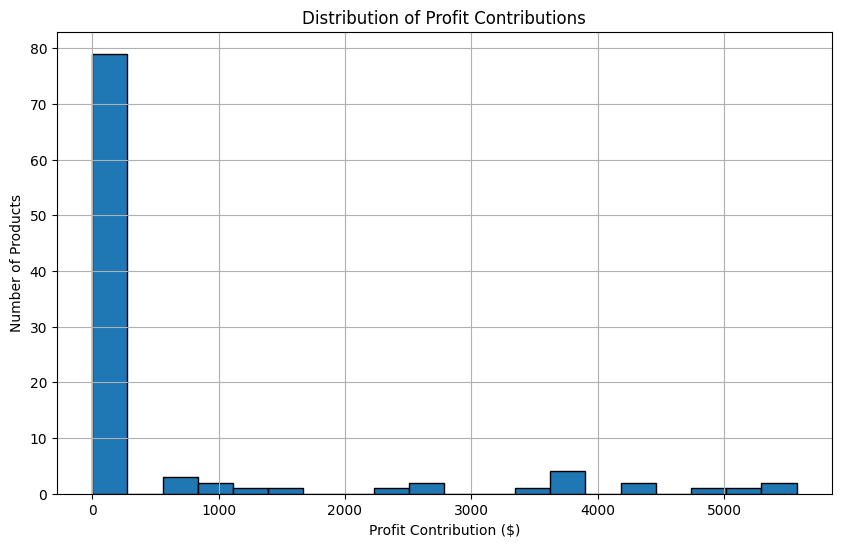

In [14]:
# Histogram
plt.figure(figsize=(10, 6))
df['Profit_Contribution'].hist(bins=20, edgecolor='black')
plt.title('Distribution of Profit Contributions')
plt.xlabel('Profit Contribution ($)')
plt.ylabel('Number of Products')
plt.show()

><font color=cyan>5. Stock Levels vs. Optimal Production Scatter Plot



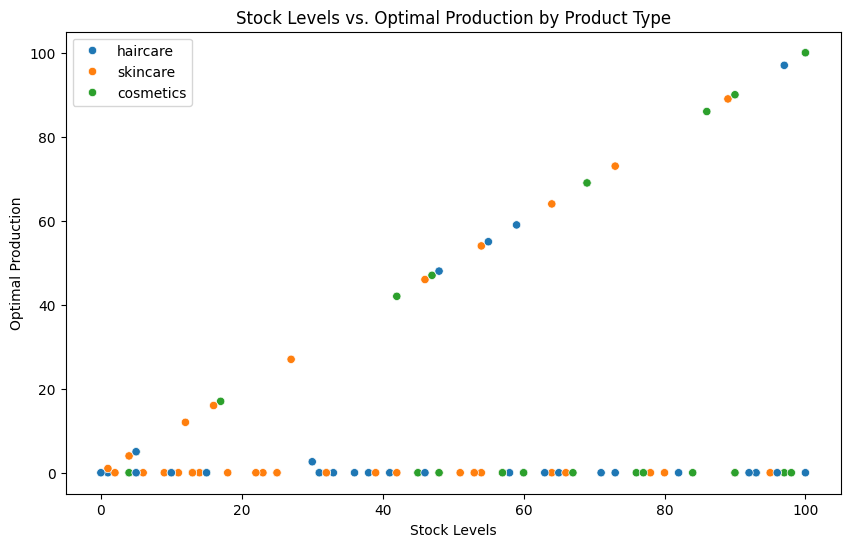

In [15]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Stock levels', y='Optimal_Production', hue='Product type')
plt.title('Stock Levels vs. Optimal Production by Product Type')
plt.xlabel('Stock Levels')
plt.ylabel('Optimal Production')
plt.legend()
plt.show()

# Business Insights and Recommendations

Based on the optimization results, here are key insights and actionable recommendations.

## Insights

- **Overall Performance:** The optimized plan achieves a total profit of approximately $63,383, with full utilization of lead time capacity.

- **Profit Breakdown:** Revenue is 33,175 and shipping costs at $7,457.
- **Product Insights:** Top products are primarily skincare and cosmetics, contributing the most to profit.
- **Constraint Utilization:** Stock is 26.7% utilized, indicating potential for expansion; lead time is fully utilized.

## Recommendations

- **Resource Allocation:** Prioritize production for high-profit products like SKU64 (skincare) and SKU59 (cosmetics).
- **Cost Optimization:** Negotiate lower manufacturing costs or explore bulk shipping to reduce expenses.
- **Inventory Management:** Monitor stock levels closely; consider increasing stock for high-demand products.
- **Scalability:** Re-run the model quarterly with updated data. For advanced scenarios, incorporate uncertainty in demand.
- **Risks:** Assumes linear costs and fixed capacities; monitor for fluctuations in demand or costs.


This model provides a data-driven foundation for supply chain decisions, potentially increasing profitability by optimizing resource use.

